# Personal Data Project
Created by Zongyuan Liu , Aug 2020
***
> Background: The objective of the project is to extract insights from a dataset that contains loan related information at a mortgatge company and answer some of the key questions raised by the stakeholder. 


***
## Agenda: <a id='agenda'></a>
### 1. <a href='#connect'>Connect to database</a>
### 2.  <a href='#data_prep'>Data Prep</a>
### 3.  <a href='#eda'>Exploratory Data Analysis</a>
- **3. a :**  <a href='#3a'>How has the loan interest rate varied over time? </a>
- **3. b :**  <a href='#3b'>How much does the interest rate differ between conforming and jumbo?</a>
- **3. c :**  <a href='#3c'>Is there a difference between interest rates in different states? </a>

### Summary of `How has the loan interest rate varied over time?`
> -  In the period of 2017~ 2019, **2018** had the *highest* avg.loan interest (4.43%), while **2017** had the *lowest* average interest rate (3.78%).
-  From 2017 through 2019, we saw the highest avg.loan interest in Nov 2018 at around 4.7% and lowest interset in Nov 2019, about 3.4%. The loan interest rate increased consistently from Nov 2017 to Nov 2018 and declined since then.
-  There is **NO** substantial seasonal change in the interest rate as we see different patterns every year.

### Summary of `How much does the interest rate differ between conforming and jumbo?`
>- On average, conforming loans has a higher interest rate (3.99% vs. 3.78%) than jumbo loans - a 5% difference.
- 14 out of 17 states have a higher average interest rate of conforming loans than jumbo loans - approximately 5% diff. While WI, NJ, and DC saw a higher interest rate in Jumbo loans - around 5% diff. 
- We're 99% confident that there is a *significant* difference in the average interest rate between the two loan types. On the state level, we're 99% confident that there is a significant difference in the average interest rate between the two loan types in the states PA, TX, CA, and AZ.

### Summary of `Is there a difference between interest rates in different states?`
>- The average interest rate varies across states: MS has the highest avg.interest rate of 4.3%, and NM has the lowest avg. interest rate of 3.5%. Every year, the average interest rate differs across states while we saw the lowest variance in the interest rate between states in 2017.
- The difference between states has been **increasing** year over year as we saw an increasing number of pairs of states that show a significant difference in the interest rate from 2017 to 2019. 
- Overall, We're 99% confident that the difference in interest rate (3 year average) between each state is **NOT** significant.
- However, on a more granular level, we're 99% confident that there are statistically significant differences in conforming loan interest rates between many states in 2018 and 2019.

## 1. Connect to database <a id='connect'></a>

In [1]:
# pip install psycopg2 for Postgres connection 
import psycopg2

conn = psycopg2.connect(user = "data_project",
                        password = "xxxx",
                        host = "xxxx",
                        database = "data_project")

<a href='#agenda'>Go back to agenda</a>

## 2. Data Prep <a id='data_prep'></a>

###  2.1 Convert tables to pandas DataFrames

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
%matplotlib inline 


loans = pd.read_sql_query(
''' SELECT * FROM loans ''',conn) 

#convert loans table to pandas DataFrame
loans = pd.DataFrame(loans, columns=['funded_at','loan_amount','rate','state','county_fips'])
loans.head(2)

,funded_at,loan_amount,rate,state,county_fips
0,2017-05-26,162000.0,3.125,PA,42003
1,2019-07-22,210550.0,3.625,NC,37111


In [3]:
counties = pd.read_sql_query(
''' SELECT * FROM counties''',conn)

#convert counties table to pandas DataFrame
counties = pd.DataFrame(counties, columns=['state','fips','loan_limit'])
counties.head(2)

,state,fips,loan_limit
0,AK,02020,726525
1,AK,02068,726525


### `2.2 Check loans and counties DataFrame seperately.`

In [4]:
loans.info()
# no missing data, no null.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
funded_at      10000 non-null object
loan_amount    10000 non-null float64
rate           10000 non-null float64
state          10000 non-null object
county_fips    10000 non-null object
dtypes: float64(2), object(3)
memory usage: 390.8+ KB


In [5]:
counties.info()
# no missing data, no null

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2102 entries, 0 to 2101
Data columns (total 3 columns):
state         2102 non-null object
fips          2102 non-null object
loan_limit    2102 non-null int64
dtypes: int64(1), object(2)
memory usage: 49.4+ KB


` **NOTE**: fips can be the same in different states`

In [6]:
counties['fips'].value_counts()
counties.loc[counties['fips'] == '06001']
counties.groupby('fips').size().sort_values(ascending = False).head(10)

#counties.loc[counties['fips'] == '48085']

fips
06001    2
48085    2
13113    2
34007    2
12097    2
28145    2
06075    2
53033    2
12019    2
19163    1
dtype: int64

### 2.3 Merge two DataFrames

In [7]:
df = loans.merge(counties,how = 'left',left_on = ['county_fips','state']
                 ,right_on = ['fips','state'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 7 columns):
funded_at      10000 non-null object
loan_amount    10000 non-null float64
rate           10000 non-null float64
state          10000 non-null object
county_fips    10000 non-null object
fips           9999 non-null object
loan_limit     9999 non-null float64
dtypes: float64(3), object(4)
memory usage: 625.0+ KB


In [8]:
df.head()

,funded_at,loan_amount,rate,state,county_fips,fips,loan_limit
0,2017-05-26,162000.0,3.125,PA,42003,42003,484350.0
1,2019-07-22,210550.0,3.625,NC,37111,37111,484350.0
2,2019-02-14,344250.0,4.500,FL,12011,12011,529000.0
3,2019-09-23,461120.0,3.750,NJ,34039,34039,726525.0
4,2019-08-08,346000.0,3.500,TX,48453,48453,484350.0


### 2.4 Drop nan

In [9]:
# find the nan record in loan table 
df.loc[(df['fips'].isna())& (df['county_fips']!='')].head()

,funded_at,loan_amount,rate,state,county_fips,fips,loan_limit
5189,2019-05-15,261500.0,3.875,NJ,34,NaN,NaN


In [10]:
# drop the Nan
df = df.dropna() 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9999 entries, 0 to 9999
Data columns (total 7 columns):
funded_at      9999 non-null object
loan_amount    9999 non-null float64
rate           9999 non-null float64
state          9999 non-null object
county_fips    9999 non-null object
fips           9999 non-null object
loan_limit     9999 non-null float64
dtypes: float64(3), object(4)
memory usage: 624.9+ KB


### 2.5 Convert funded_at to datetime

In [11]:
df['funded_at']=pd.to_datetime(df['funded_at'])

### 2.6 Set funded_at as index

In [12]:
df = df.set_index('funded_at')

In [13]:
df.head()

,loan_amount,rate,state,county_fips,fips,loan_limit
funded_at,,,,,,
2017-05-26,162000.0,3.125,PA,42003,42003,484350.0
2019-07-22,210550.0,3.625,NC,37111,37111,484350.0
2019-02-14,344250.0,4.500,FL,12011,12011,529000.0
2019-09-23,461120.0,3.750,NJ,34039,34039,726525.0
2019-08-08,346000.0,3.500,TX,48453,48453,484350.0


In [14]:
#Explore the record count by year 
df.groupby([df.index.year,df.index.month]).size().unstack()
# incomplete data in 2011 and 2016. no data from 2012-2015

funded_at,1,2,3,4,5,6,7,8,9,10,11,12
funded_at,,,,,,,,,,,,
2011,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.0,102.0,56.0
2017,65.0,51.0,41.0,37.0,41.0,59.0,82.0,88.0,63.0,78.0,88.0,68.0
2018,85.0,93.0,137.0,169.0,189.0,255.0,271.0,295.0,261.0,320.0,294.0,258.0
2019,267.0,305.0,386.0,535.0,619.0,620.0,680.0,794.0,1000.0,1177.0,25.0,NaN


### 2.7 Drop data prior to 2017 due to incomplete data in 2011 and 2016

In [15]:
# Missing data from 2012-2015.
# Finalize the data as below
df= df[df.index.year >=2017] 

<a href='#agenda'>Go back to agenda</a>

***
# 3. Exploratory Data Analysis  <a id='eda'></a>

### 3. a. How has the loan interest rate varied over time? <a id='3a'></a>
> note: as mentioned, we're going to look at trend over the period of 2017-2019 as data is missing/incomplete during 2011 -2016

### 3.a.1 Calculate and plot Avg. loan interest rate by year

In [16]:
# calculate avg. loan interest rate by year
rate = df['rate']
rate_by_year = rate.groupby([(rate.index.year)]).mean()
print('average interest rate by year:', rate_by_year)

average interest rate by year: funded_at
2017    3.775460
2018    4.429911
2019    3.836757
Name: rate, dtype: float64


three year average(%): 4.014042548010129


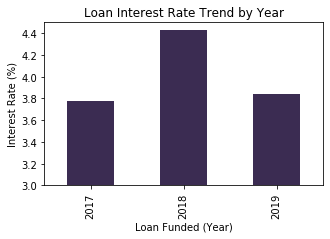

In [17]:
rate_by_year.plot(kind='bar',figsize =(5,3),color = '#3b2c52')
plt.style.use('tableau-colorblind10')
plt.title('Loan Interest Rate Trend by Year')
plt.ylabel('Interest Rate (%)')
plt.xlabel('Loan Funded (Year)')
plt.ylim(3,4.5)
print('three year average(%):',rate_by_year.mean())

### 3.a.1 Findings:

>  In the period of 2017~ 2019, **2018** has the *highest* avg.loan interest (4.43%), while **2017** had the *lowest* average interest rate (3.78%)

### 3.a.2 Plot trend of avg. loan interest rate

lowest interest rate: 3.4246 
highest interest rate: 4.698643410852713 
average interest rate: 4.019366404053524


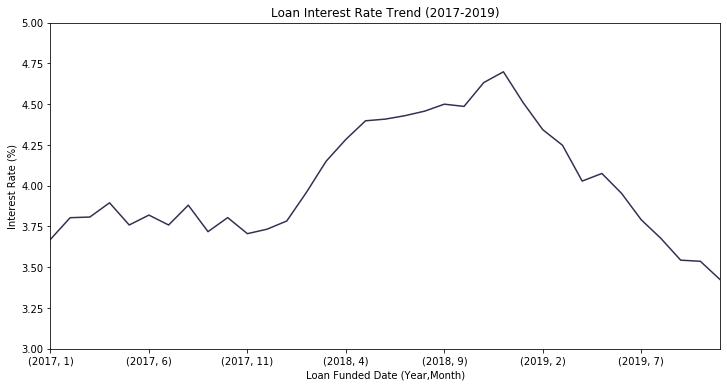

In [18]:
rate_by_date = rate.groupby([(rate.index.year),(rate.index.month)]).mean()

rate_by_date.plot(kind ='line',figsize = (12,6),color ='#3b2c52')
plt.title('Loan Interest Rate Trend (2017-2019)')
plt.ylabel('Interest Rate (%)')
plt.xlabel('Loan Funded Date (Year,Month)')
plt.ylim(3,5)
plt.style.use('tableau-colorblind10')# color blind friendly

print('lowest interest rate:',rate_by_date.min(),'\nhighest interest rate:',
      rate_by_date.max(),'\naverage interest rate:',rate_by_date.mean())
# Highest-> Nov 2018: 4.7%
# Lowest -> Nov 2019: 3.4%

###  Findings:
> From 2017 through 2019, we saw the *highest* avg.loan interest in **Nov 2018** at around 4.7% and *lowest* interset in **Nov 2019**, about 3.4%. The loan interest rate increased consistently from Nov 2017 to Nov 2018 and declined since then.

### 3.a.3 Plot Avg. loan interest rate by month

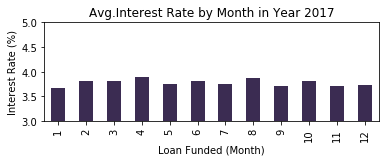

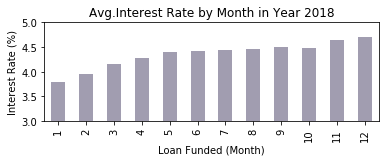

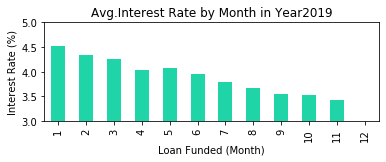

In [19]:
# calculate avg. loan interest rate by month
rate_by_month = rate.groupby([(rate.index.month),(rate.index.year)]).mean()
rate_by_month = pd.DataFrame(rate_by_month)
m = rate_by_month.unstack()
m_2017= m.iloc[:,0]
m_2018= m.iloc[:,1]
m_2019= m.iloc[:,2]

plt.figure()
plt.subplot(211)
plt.title('Avg.Interest Rate by Month in Year 2017')
m_2017.plot(kind='bar',color ='#3b2c52')
plt.ylabel('Interest Rate (%)')
plt.xlabel('Loan Funded (Month)')
plt.ylim(3,5)
plt.show()

plt.subplot(212)
m_2018.plot(kind='bar',color ='#a19db0')
plt.title('Avg.Interest Rate by Month in Year 2018')
plt.ylabel('Interest Rate (%)')
plt.xlabel('Loan Funded (Month)')
plt.ylim(3,5)
plt.show()

plt.subplot(212)
plt.title('Avg.Interest Rate by Month in Year2019')
m_2019.plot(kind='bar',color ='#1fd5a8')
plt.ylabel('Interest Rate (%)')
plt.xlabel('Loan Funded (Month)')
plt.ylim(3,5)
plt.show()

# # Highest-> Dec
# # Lowest -> Oct

### Findings:
> There is **NO** substantial seasonal change in the interest rate as we see different patterns every year.

***
### Summary of `How has the loan interest rate varied over time?`
> -  In the period of 2017~ 2019, **2018** had the *highest* avg.loan interest (4.43%), while **2017** had the *lowest* average interest rate (3.78%).
-  From 2017 through 2019, we saw the highest avg.loan interest in Nov 2018 at around 4.7% and lowest interset in Nov 2019, about 3.4%. The loan interest rate increased consistently from Nov 2017 to Nov 2018 and declined since then.
-  There is **NO** substantial seasonal change in the interest rate as we see different patterns every year.

### 3.b. How much does the interest rate differ between conforming and jumbo? <a id='3b'></a>

> ###  We'll be exploring the difference per the following order:
1. By loan type 
2. By loan type and state

### 3.b.1 Create a new column 'loan_type' based on the logics were given as below: 
- Conforming is when a loan amount is lower or equal to the conforming loan limit for that county
- Jumbo is when a loan amount is larger than that.

In [20]:
#### Create a new column [loan_type]
df['diff'] =df['loan_amount'] - df['loan_limit']
df['loan_type'] = df['diff'].apply (lambda x : 'conforming' if x <=0 else 'jumbo')
df.head()

,loan_amount,rate,state,county_fips,fips,loan_limit,diff,loan_type
funded_at,,,,,,,,
2017-05-26,162000.0,3.125,PA,42003,42003,484350.0,-322350.0,conforming
2019-07-22,210550.0,3.625,NC,37111,37111,484350.0,-273800.0,conforming
2019-02-14,344250.0,4.500,FL,12011,12011,529000.0,-184750.0,conforming
2019-09-23,461120.0,3.750,NJ,34039,34039,726525.0,-265405.0,conforming
2019-08-08,346000.0,3.500,TX,48453,48453,484350.0,-138350.0,conforming


### 3.b.2 Explore interest rate by loan type

In [21]:
df.groupby(['loan_type']).agg({'rate':['count','max','min','mean','median']})

rate                               
           count    max    min      mean median
loan_type                                      
conforming  9484  6.625  2.375  3.998431  4.000
jumbo        312  5.000  2.875  3.767051  3.625

In [22]:
df.groupby([df.index.year,'loan_type']).agg({'rate':['count','max','min','mean','median']})

rate                                
                     count    max    min      mean  median
funded_at loan_type                                       
2017      conforming   749  5.750  2.750  3.771696  3.8750
          jumbo         12  4.375  3.500  4.010417  4.0000
2018      conforming  2565  6.625  2.750  4.433772  4.3750
          jumbo         62  5.000  3.250  4.270161  4.3750
2019      conforming  6170  6.625  2.375  3.844975  3.8750
          jumbo        238  4.875  2.875  3.623718  3.5625

### Findings:
> On average, conforming loan has a **higher** interest rate (4.0% vs. 3.8%) than jumbo loan- a 5% difference.

### 3.b.3 Check the kde distribution of conforming and jumbo group

In [23]:
# overall
import scipy.stats as stats 
a = df.loc[(df['loan_type']=='conforming')]['rate']
b = df.loc[(df['loan_type']=='jumbo')]['rate']

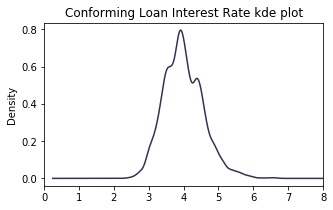

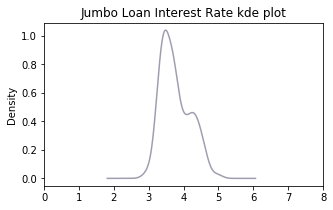

In [24]:
# Plot conforming 
a.plot(kind='kde',figsize =(5,3),color = '#3b2c52')
plt.xlim(0,8)
plt.title('Conforming Loan Interest Rate kde plot')
plt.show()

# Plot jumbo 
b.plot(kind='kde',figsize =(5,3),color = '#a19db0')
plt.xlim(0,8)
plt.title('Jumbo Loan Interest Rate kde plot')
plt.show()

#### Findings:
> The Kde distribution of both conforming and jumbo loans are close to Normal.

### 3.b.4 Run A/B test to test if there is a statistical significant difference in interest rates between the two loan types

#### Why Welch test? 
> The sample sizes and sample variances between the two groups are **NOT** equal.

In [25]:
t_score, p_value = stats.ttest_ind(a,b,equal_var=False)
print(t_score,p_value)

9.390360678281832 7.948297023645028e-19


### Findings:
> P value < 0.01 => We're 99% confident that there is a **siginificant** difference in interest rate between conforming and jumbo loan.

### 3.b.5 Explore avg. interest rate by loan type and state; Plot interest rate percent_difference between loan types by state

In [26]:
dt =pd.DataFrame(df.groupby(['state','loan_type'])['rate'].mean())
dt= dt.unstack()
#Drop states that have only 1 loan type
dt = dt.dropna()
# create a percent diff column (conforming - jumnbo)
dt['percent_difference']= (dt.iloc[:,0] - dt.iloc[:,1])*100/(dt.iloc[:,1])
dt.sort_values('percent_difference', ascending = False)

rate           percent_difference
loan_type conforming     jumbo                   
state                                            
CT          3.942941  3.500000          12.655462
PA          4.009077  3.623462          10.642178
TX          4.031160  3.654925          10.293920
AZ          3.983879  3.612083          10.293122
TN          4.161572  3.875000           7.395408
GA          4.199757  3.990357           5.247637
MI          4.049125  3.870000           4.628540
FL          4.107394  3.925714           4.627950
CA          3.911182  3.739747           4.584108
WA          3.896639  3.773194           3.271628
OR          3.940451  3.873333           1.732805
CO          3.951155  3.897188           1.384791
IL          4.088213  4.062500           0.632941
NC          3.962582  3.943182           0.491999
NJ          3.988613  4.050000          -1.515732
DC          3.938725  4.125000          -4.515746
WI          3.966912  4.375000          -9.327731

In [27]:
print(dt.loc[dt['percent_difference']>0].mean())
print(dt.loc[dt['percent_difference']<0].mean())

                    loan_type 
rate                conforming    4.016795
                    jumbo         3.810049
percent_difference                5.563035
dtype: float64
                    loan_type 
rate                conforming    3.964750
                    jumbo         4.183333
percent_difference               -5.119736
dtype: float64


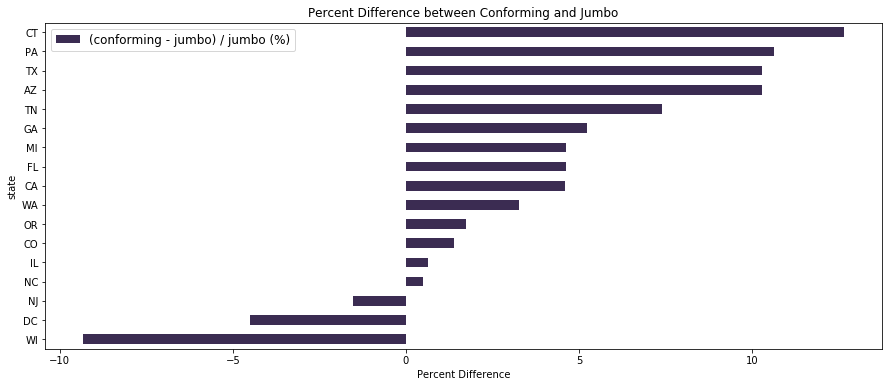

In [28]:
dt.iloc[:,2].sort_values(ascending = True).plot(kind='barh',color ='#3b2c52',figsize=(15,6))
plt.title('Percent Difference between Conforming and Jumbo')
plt.xlabel('Percent Difference')
dt['percent_difference'].mean()
plt.legend(['(conforming - jumbo) / jumbo (%)'],prop={'size': 12})
plt.show()

### Findings:
> 14 out of 17 states have a **higher** average interest rate of conforming loans than jumbo loans. While WI, NJ, and DC saw a **lower** interest rate in conforming loans.* (Please note: we're only looking at states that provide both loan types)

### 3.b.5 Run A/B test to tell if there is a statistical significant difference in interest rates between the two loan types in each state.

In [30]:
for i in df['state'].unique():
    c = df.loc[(df['loan_type']=='conforming') & (df['state'] ==i)]['rate']
    j = df.loc[(df['loan_type']=='jumbo') & (df['state'] == i)]['rate']
    t_score, p_value = stats.ttest_ind(c,j,equal_var=False)
    if p_value <= 0.01:
        print('State:',i,p_value)

State: PA 0.0013412447034931098
State: TX 1.5434001835921845e-11
State: CA 0.0003222320636901088
State: AZ 0.002527542761902649


### Findings:
> We're 99% confidence that there are **significant** differences between loan types in the following states: PA, TX,CA and AZ.

***
### Summary of `How much does the interest rate differ between conforming and jumbo?`
>- On average, conforming loans has a higher interest rate (3.99% vs. 3.78%) than jumbo loans - a 5% difference.
- 14 out of 17 states have a higher average interest rate of conforming loans than jumbo loans - approximately 5% diff. While WI, NJ, and DC saw a higher interest rate in Jumbo loans - around 5% diff. 
- We're 99% confident that there is a significant difference in the average interest rate between the two loan types.
- On the state level, we're 99% confident that there is a significant difference in the average interest rate between the two loan types in the states PA, TX, CA, and AZ.

<a href='#agenda'>Go back to agenda</a>

### 3.c. Is there a difference between interest rates in different states? <a id='3c'></a>

> ### We'll be exploring the difference as the following order:
1. By state 
2. By state and year
3. By state, year, and loan type.

###  3.c.1 Explore and plot interest rate by state

In [31]:
r_state= df.groupby(['state'])['rate'].agg({'mean'})
r_state= pd.DataFrame(r_state)
r_state.head()

,mean
state,
AK,4.000000
AL,4.118151
AR,3.868590
AZ,3.974680
CA,3.901641


standard deviation: [0.18703259] 
average: [3.93193629] 
highest: [4.32407407] 
lowest: [3.45982143]


Text(0.5, 0, 'Interest Rate (%)')

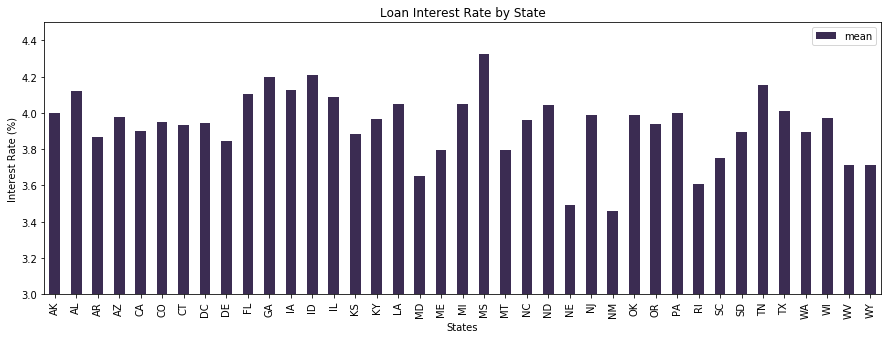

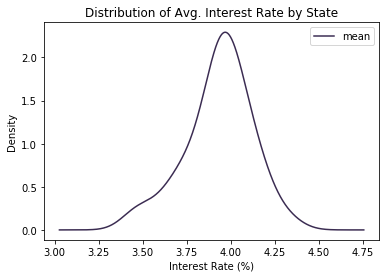

In [32]:
# plot interest rate by state
r_state.plot(kind='bar',figsize =(15,5),color = '#3b2c52')
plt.title('Loan Interest Rate by State')
plt.ylabel('Interest Rate (%)')
plt.xlabel('States')
plt.ylim(3,4.5)


#standard deviation,mean,max 
print('standard deviation:', r_state.std().values,
      '\naverage:',r_state.mean().values,'\nhighest:',r_state.max().values,'\nlowest:',r_state.min().values)

# plot kde distribution of interest rate 
r_state.plot(kind = 'kde',color = '#3b2c52')
plt.title('Distribution of Avg. Interest Rate by State')
plt.xlabel('Interest Rate (%)')

### Findings:
> Average interest rate varies across states - MS has the **highest** avg.interest rate of 4.32% and NM has the **lowest** avg. interest rate of 3.45%.

### 3.c.2 Run A/B test to tell if there is a statistical significant difference in interest rates between each state.

In [33]:
df.head()

,loan_amount,rate,state,county_fips,fips,loan_limit,diff,loan_type
funded_at,,,,,,,,
2017-05-26,162000.0,3.125,PA,42003,42003,484350.0,-322350.0,conforming
2019-07-22,210550.0,3.625,NC,37111,37111,484350.0,-273800.0,conforming
2019-02-14,344250.0,4.500,FL,12011,12011,529000.0,-184750.0,conforming
2019-09-23,461120.0,3.750,NJ,34039,34039,726525.0,-265405.0,conforming
2019-08-08,346000.0,3.500,TX,48453,48453,484350.0,-138350.0,conforming


In [34]:
for i in df['state'].unique():
    c = df.loc[df['state'] ==i]['rate']
    j = df.loc[df['state'] == i]['rate']
    t_score, p_value = stats.ttest_ind(c,j,equal_var=False)
    if p_value <= 0.01:
        print('State:',i,p_value)

### Findings:
> We're 99% confident that the difference in interest rate between each state is **NOT** significant.

### 3.c.3 Explore and plot interest rate by state and year

In [35]:
r_s_year= df.groupby(['state',df.index.year])['rate'].agg({'mean','count'})
r_s_year.unstack().head(2)

count            mean                 
funded_at  2017 2018  2019 2017   2018      2019
state                                           
AK          NaN  NaN   9.0  NaN    NaN  4.000000
AL          NaN  1.0  72.0  NaN  5.375  4.100694

std: 2017: 0.1138701440242156 2018: 0.37919056642992854 2018: 0.37919056642992854


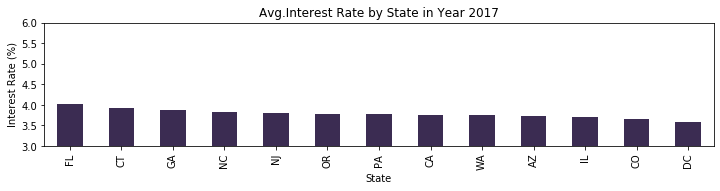

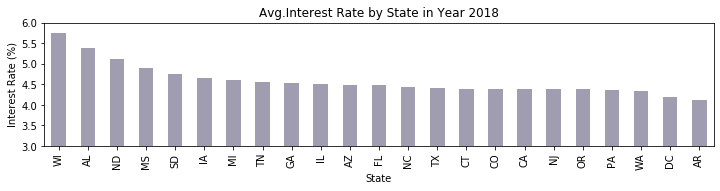

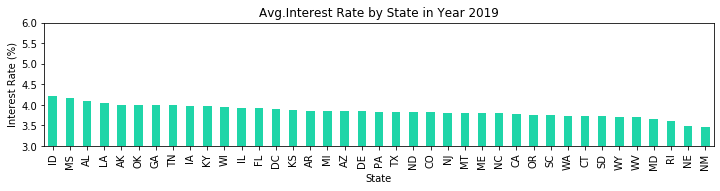

In [48]:
r_s_year= df.groupby(['state',df.index.year])['rate'].mean()
r_s_year = pd.DataFrame(r_s_year)
rr=r_s_year.unstack() 

rr_2017= rr.iloc[:,0].dropna().sort_values(ascending = False)
rr_2018= rr.iloc[:,1].dropna().sort_values(ascending = False)
rr_2019= rr.iloc[:,2].dropna().sort_values(ascending = False)

print('std:','2017:',rr_2017.std(),'2018:',rr_2018.std(),'2018:',rr_2018.std())

plt.figure()
plt.subplot(211)
plt.title('Avg.Interest Rate by State in Year 2017')
rr_2017.plot(kind='bar',color ='#3b2c52',figsize=(12,5))
plt.ylabel('Interest Rate (%)')
plt.xlabel('State')
plt.ylim(3,6)
plt.show()

plt.subplot(212)
rr_2018.plot(kind='bar',color ='#a19db0',figsize=(12,5))
plt.title('Avg.Interest Rate by State in Year 2018')
plt.ylabel('Interest Rate (%)')
plt.xlabel('State')
plt.ylim(3,6)
plt.show()

plt.subplot(212)
plt.title('Avg.Interest Rate by State in Year 2019')
rr_2019.plot(kind='bar',color ='#1fd5a8',figsize=(12,5))
plt.ylabel('Interest Rate (%)')
plt.xlabel('State')
plt.ylim(3,6)
plt.show()

### Findings
> Every year, average interest rate varies across states. We saw the smallest standard deviation in 2017, meaning the variance in interest rate between states is the smallest. 

### 3.c.5: Run A/B test to tell if there is a statistical significant difference in interest rates every year between each state.

In [49]:
# create segment for each year
a_2017 = df.loc[df.index.year ==2017].dropna()
b_2018 = df.loc[df.index.year ==2018].dropna()
c_2019 = df.loc[df.index.year ==2019].dropna()

#### 3.c.5.1: Compare 2017 loan interest rate between states

In [50]:
state_list = a_2017['state'].unique()
for i, state in enumerate(state_list):
    for j in state_list[i+1:]:
        a = a_2017.loc[a_2017['state']== state]['rate']
        b = a_2017.loc[a_2017['state']== j]['rate']
        t_score, p_value = stats.ttest_ind(a,b,equal_var =False)
        if p_value <= 0.01:
            print('There is a significant difference of interest rate between these states:',state,j,p_value)

There is a significant difference of interest rate between these states: FL CO 0.0024675019616473095


#### 3.c.5.2: Compare 2018 loan interest rate between states

In [60]:
state_list = b_2018['state'].unique()
for i, state in enumerate(state_list):
    for j in state_list[i+1:]:
        a = b_2018.loc[b_2018['state']== state]['rate']
        b = b_2018.loc[b_2018['state']== j]['rate']
        t_score, p_value = stats.ttest_ind(a,b,equal_var =False)
        if p_value <= 0.01:
            print('There is a significant difference of interest rate between these states:',state,j,p_value)

There is a significant difference of interest rate between these states: TX GA 0.0016854777234377465
There is a significant difference of interest rate between these states: TX MI 0.009769514823571185
There is a significant difference of interest rate between these states: AZ WA 0.008236905380814856
There is a significant difference of interest rate between these states: FL WA 0.0008181930740633726
There is a significant difference of interest rate between these states: NJ GA 0.002332290726496019
There is a significant difference of interest rate between these states: NJ MI 0.006444655709902773
There is a significant difference of interest rate between these states: IL WA 0.004876082369294944
There is a significant difference of interest rate between these states: WA TN 0.0016859348395991635
There is a significant difference of interest rate between these states: WA GA 2.5414223279981368e-05
There is a significant difference of interest rate between these states: WA MI 0.00126308711546

#### 3.c.5.3: Compare 2019 loan interest rate between states

In [52]:
state_list = c_2019['state'].unique()
for i, state in enumerate(state_list):
    for j in state_list[i+1:]:
        a = c_2019.loc[c_2019['state']== state]['rate']
        b = c_2019.loc[c_2019['state']== j]['rate']
        t_score, p_value = stats.ttest_ind(a,b,equal_var =False)
        if p_value <= 0.01:
            print('There is a significant difference of interest rate between these states:',state,j,p_value)

There is a significant difference of interest rate between these states: NC FL 6.238147434722862e-05
There is a significant difference of interest rate between these states: NC GA 5.290813063027532e-07
There is a significant difference of interest rate between these states: NC IL 0.002442159855415095
There is a significant difference of interest rate between these states: NC TN 0.0002898728871630279
There is a significant difference of interest rate between these states: NC LA 0.007853578545457714
There is a significant difference of interest rate between these states: NC AL 0.00024702726515263296
There is a significant difference of interest rate between these states: NC NM 0.00020852405697236554
There is a significant difference of interest rate between these states: FL NJ 0.0006279225813086378
There is a significant difference of interest rate between these states: FL TX 0.0009545626434623632
There is a significant difference of interest rate between these states: FL CA 1.8836749970

There is a significant difference of interest rate between these states: TN NE 0.0005100325154579745
There is a significant difference of interest rate between these states: CO AL 0.000623972669855222
There is a significant difference of interest rate between these states: CO NM 7.928392912744591e-05
There is a significant difference of interest rate between these states: LA CT 0.002629574463353881
There is a significant difference of interest rate between these states: LA NM 4.018375815136135e-06
There is a significant difference of interest rate between these states: LA RI 0.0007700336180126743
There is a significant difference of interest rate between these states: LA NE 0.00035444187877658665
There is a significant difference of interest rate between these states: CT AL 9.321368798813168e-05
There is a significant difference of interest rate between these states: CT NM 0.005108724270370639
There is a significant difference of interest rate between these states: DE NM 0.008923394934

### Findings:
> We saw an increasing number of pairs of states that show a significant difference in the interest rate from 2017 to 2019. 

### 3.c.6: Explore interest rate by state, year and loan type.

#### 3.c.6.1: Run A/B test Run to test if there is a statistical significant difference in interest rates between the two loan types every year in each state.

In [53]:
# create segments by year and loan type`
c_2017 = df.loc[(df['loan_type']=='conforming')& (df.index.year ==2017)].dropna()
j_2017 = df.loc[(df['loan_type']=='jumbo')& (df.index.year ==2017)].dropna()
c_2018 = df.loc[(df['loan_type']=='conforming')& (df.index.year ==2018)].dropna()
j_2018 = df.loc[(df['loan_type']=='jumbo')& (df.index.year ==2018)].dropna()
c_2019 = df.loc[(df['loan_type']=='conforming')& (df.index.year ==2019)].dropna()
j_2019 = df.loc[(df['loan_type']=='jumbo')& (df.index.year ==2019)].dropna()

#### 3.c.6.2: Compare 2017 conforming loan interest rate between states

In [54]:
state_list = c_2017['state'].unique()

for i, state in enumerate(state_list):
    for j in state_list[i+1:]:
        a = c_2017.loc[c_2017['state']== state]['rate']
        b = c_2017.loc[c_2017['state']== j]['rate']
        t_score, p_value = stats.ttest_ind(a,b,equal_var =False)
        if p_value <= 0.01:
            print('There is a significant difference of interest rate between these states:',state,'&',j,
                  '\nwith p values',p_value)

There is a significant difference of interest rate between these states: FL & CO 
with p values 0.0024675019616473095


#### 3.c.6.3:  Compare 2017 jumbo loan interest rate between state`

In [55]:
state_list = j_2017['state'].unique()
for i, state in enumerate(state_list):
    for j in state_list[i+1:]:
        a = j_2017.loc[j_2017['state']== state]['rate']
        b = j_2017.loc[j_2017['state']== j]['rate']
        t_score, p_value = stats.ttest_ind(a,b,equal_var =False)
        if p_value <= 0.01:
            print(state,j,p_value)

`no significant pair of state`

#### 3.c.6.4: Compare 2018 conforming loan interest rate between states

In [56]:
state_list = c_2018['state'].unique()
for i, state in enumerate(state_list):
    for j in state_list[i+1:]:
        a = c_2018.loc[c_2018['state']== state]['rate']
        b = c_2018.loc[c_2018['state']== j]['rate']
        t_score, p_value = stats.ttest_ind(a,b,equal_var =False)
        if p_value <= 0.01:
            print('There is a significant difference of interest rate between these states:',state,j,p_value)

There is a significant difference of interest rate between these states: TX GA 0.003972878138841825
There is a significant difference of interest rate between these states: FL WA 0.002732252156419184
There is a significant difference of interest rate between these states: NJ GA 0.0035366282205118423
There is a significant difference of interest rate between these states: NJ MI 0.007510389007442566
There is a significant difference of interest rate between these states: IL WA 0.009581889172877214
There is a significant difference of interest rate between these states: WA TN 0.003585580498570645
There is a significant difference of interest rate between these states: WA GA 0.0001308893042837242
There is a significant difference of interest rate between these states: WA MI 0.002126919017115973
There is a significant difference of interest rate between these states: TN PA 0.007804542026130435
There is a significant difference of interest rate between these states: GA CA 0.00116295994999293

#### 3.c.6.5: Compare 2018 jumbo loan interest rate between states

In [57]:
state_list = j_2018['state'].unique()
for i, state in enumerate(state_list):
    for j in state_list[i+1:]:
        a = j_2018.loc[j_2018['state']== state]['rate']
        b = j_2018.loc[j_2018['state']== j]['rate']
        t_score, p_value = stats.ttest_ind(a,b,equal_var =False)
        if p_value <= 0.01:
            print(state,j,p_value)

`no significant pair of state`

####  3.c.6.6: Compare 2019 conforming loan interest rate between states

In [58]:
state_list = c_2019['state'].unique()
for i, state in enumerate(state_list):
    for j in state_list[i+1:]:
        a = c_2019.loc[c_2019['state']== state]['rate']
        b = c_2019.loc[c_2019['state']== j]['rate']
        t_score, p_value = stats.ttest_ind(a,b,equal_var =False)
        if p_value <= 0.01:
            print('There is a significant difference of interest rate between these states:',state,j,p_value)

There is a significant difference of interest rate between these states: NC FL 9.217757120190425e-05
There is a significant difference of interest rate between these states: NC GA 4.316237133537607e-07
There is a significant difference of interest rate between these states: NC IL 0.0038109078709452414
There is a significant difference of interest rate between these states: NC TN 0.000249608982706655
There is a significant difference of interest rate between these states: NC LA 0.008442376039687699
There is a significant difference of interest rate between these states: NC AL 0.00027733137783010674
There is a significant difference of interest rate between these states: NC NM 0.00019366690215225156
There is a significant difference of interest rate between these states: FL NJ 0.0005017760089339131
There is a significant difference of interest rate between these states: FL TX 0.009009295694220121
There is a significant difference of interest rate between these states: FL CA 4.00257422920

There is a significant difference of interest rate between these states: DE NM 0.008923394934475483
There is a significant difference of interest rate between these states: KY NM 1.4227594184897175e-05
There is a significant difference of interest rate between these states: KY RI 0.0029943019939079104
There is a significant difference of interest rate between these states: KY NE 0.0012130347036717708
There is a significant difference of interest rate between these states: MD AL 0.006663614259680648
There is a significant difference of interest rate between these states: KS NM 0.00028601314621306135
There is a significant difference of interest rate between these states: KS NE 0.0062156956548377225
There is a significant difference of interest rate between these states: WI NM 1.5456443513193293e-05
There is a significant difference of interest rate between these states: WI RI 0.004271852702985619
There is a significant difference of interest rate between these states: WI NE 0.0017054170

### `3.c.6.6 Compare 2019 jumbo loan interest rate between states` 

In [59]:
state_list = j_2019['state'].unique()
for i, state in enumerate(state_list):
    for j in state_list[i+1:]:
        a = j_2019.loc[j_2019['state']== state]['rate']
        b = j_2019.loc[j_2019['state']== j]['rate']
        t_score, p_value = stats.ttest_ind(a,b,equal_var =False)
        if p_value <= 0.01:
            print('There is a significant difference of interest rate between these states:',state,j,p_value)

There is a significant difference of interest rate between these states: OR CT 0.0030620468142053344
There is a significant difference of interest rate between these states: CT CO 0.008587306931422959
There is a significant difference of interest rate between these states: CT FL 0.009087715274439507
There is a significant difference of interest rate between these states: CT NJ 0.006853230264848244


### Summary of `Is there a difference between interest rates in different states?`
>- The average interest rate varies across states: MS has the highest avg.interest rate of 4.3%, and NM has the lowest avg. interest rate of 3.5%. Every year, the average interest rate differs across states while we saw the lowest variance in the interest rate between states in 2017.
- The difference between states has been **increasing** year over year as we saw an increasing number of pairs of states that show a significant difference in the interest rate from 2017 to 2019. 
- Overall, We're 99% confident that the difference in interest rate (3 year average) between each state is **NOT** significant.
- However, on a granular level, we're 99% confident that there are statistically significant differences in conforming loan interest rates between many states in 2018 and 2019.

<a href='#agenda'>Go back to agenda</a>